# 8. Modified DQN

## 8.1. Intro

## 8.2. Double DQN

传统DQN：
$$
r + \gamma\max_{a'}Q_{\omega^{-}}(s', a') = r + \gamma \max_{a'}Q_{\omega^{-}}(s', \argmax_{a'}(s', a'))
$$

为了防止高估，改为
$$
r + \gamma Q_{\omega^-}(s', \argmax_{a'}Q_\omega(s', a'))
$$

In [27]:
import random
import gym
import numpy as np
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_ # 这样写np不用降级
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

class Qnet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(Qnet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    
  def forward(self, x):
    x = F.relu(self.fc1(x)) 
    return self.fc2(x)

In [28]:
class DQN:
  '''DQN '''
  def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
              epsilon, target_update, device, dqn_type='VanillaDQN'):
    self.action_dim = action_dim
    self.q_net = Qnet(state_dim, hidden_dim,
                      self.action_dim).to(device)
    # 目标网络
    self.target_q_net = Qnet(state_dim, hidden_dim, 
                              self.action_dim).to(device)
    # Adam 优化器
    self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
    self.gamma = gamma
    self.epsilon = epsilon
    self.target_update = target_update #  目标网络更新频率
    self.count = 0 # 计数器,记录更新次数
    self.dqn_type = dqn_type #+++
    self.device = device
    
  def take_action(self, state): # epsilon-贪婪策略采取动作
    if np.random.random() < self.epsilon:
      action = np.random.randint(self.action_dim)
    else:
      state = torch.tensor([state], dtype=torch.float).to(self.device)
      action = self.q_net(state).argmax().item()
    return action
  
  # ++++
  def max_q_value(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    return self.q_net(state).max().item()
  # ++++
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], 
                          dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'],
                            dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],
                                dtype = torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'],
                          dtype=torch.float).view(-1, 1).to(self.device)
    q_values = self.q_net(states).gather(1, actions) # Q值
    # 下个状态的最大Q值
    # ++++
    if self.dqn_type == 'DoubleDQN': 
      max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
      max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
    else: #+++
      max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) #^^^
    q_targets = rewards + self.gamma * max_next_q_values * (1 - dones) # TD
    dqn_loss = torch.mean(F.mse_loss(q_values, q_targets)) # 均方误差损失
    self.optimizer.zero_grad() 
    dqn_loss.backward()
    self.optimizer.step()
    
    if self.count % self.target_update == 0:
      self.target_q_net.load_state_dict(
        self.q_net.state_dict()
      ) # 更新目标网络
    self.count += 1

In [29]:
lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name ='Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11 # 主动划分区间 env.action_space.n

def dis_to_con(discrete_action, env, action_dim): 
  action_lowbound = env.action_space.low[0]
  action_upbound = env.action_space.high[0]
  return action_lowbound + (discrete_action / (action_dim - 1)) * \
                          (action_upbound - action_lowbound)



In [30]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
  return_list = []
  max_q_value_list = []
  max_q_value = 0
  
  for i in range(10):
    with tqdm(total=int(num_episodes / 10),desc='Iteration %d' % i) as pbar:
      for i_episode in range(int(num_episodes / 10)):
        episode_return = 0
        state, _ = env.reset(seed=0)
        done = False
        while not done:
          action = agent.take_action(state)
          # ++++
          max_q_value = agent.max_q_value(
            state) * 0.005 + max_q_value * 0.995 # 平滑化
          max_q_value_list.append(max_q_value)
          action_continuous = dis_to_con(action, env, agent.action_dim)
          # ++++
          next_state, reward, terminated, truncated, _ = env.step([action_continuous])
          done = terminated or truncated
          replay_buffer.add(state, action, reward, next_state, done)
          state = next_state
          episode_return += reward
          
          # 当buffer数据的数量超过一定值后,才进行Q网络训练
          if replay_buffer.size() > minimal_size:
            b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
            transition_dict = {
              'states': b_s,
              'actions': b_a,
              'next_states': b_ns,
              'rewards': b_r,
              'dones': b_d
            }
            agent.update(transition_dict)
        return_list.append(episode_return)
        if (i_episode + 1) % 10 == 0:
          pbar.set_postfix({
            'episode':
            '%d' % (num_episodes / 10 * i + i_episode + 1),
            'return':
            '%.3f' %np.mean(return_list[-10:])
          })
        pbar.update(1)
  return return_list, max_q_value_list


Iteration 9: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s, episode=500, return=-172.658]


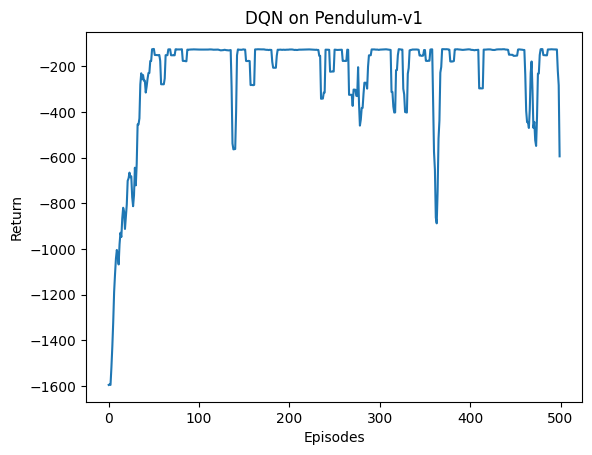

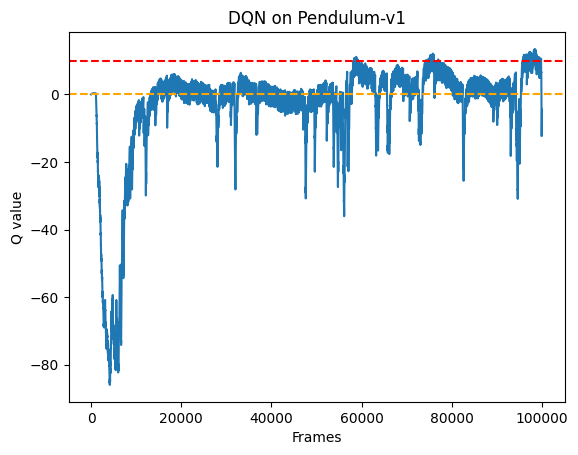

In [31]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, 
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

Iteration 9: 100%|██████████| 50/50 [00:25<00:00,  1.92it/s, episode=500, return=-126.518]


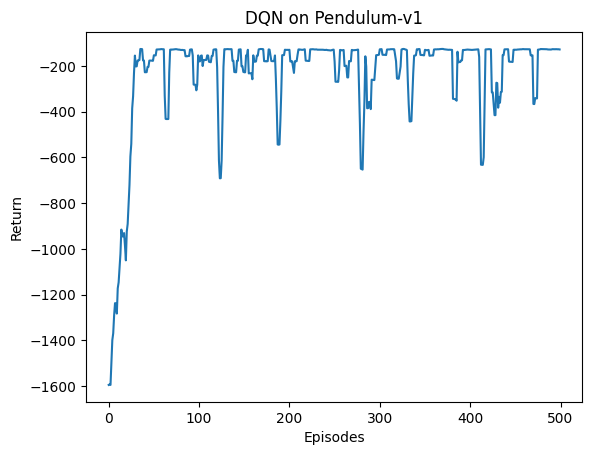

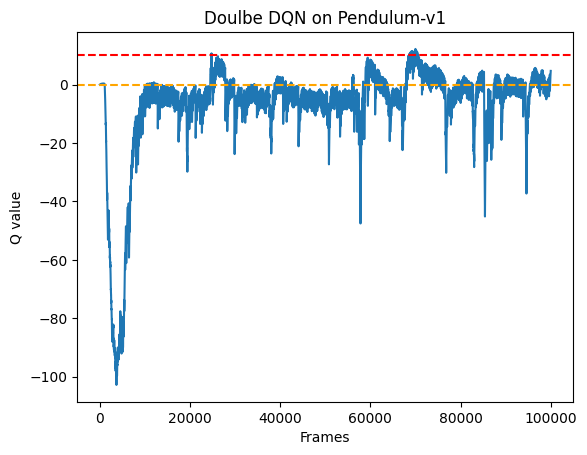

In [32]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, 
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Doulbe DQN on {}'.format(env_name))
plt.show()

## 8.4. Dueling DQN

$Q_{\eta, \alpha, \beta}(s, a) = V_{\eta, \alpha}(s) + A_{\eta, \beta}(s, a)$

$Q_{\eta, \alpha, \beta}(s, a) = V_{\eta, \alpha}(s) + A_{\eta, \beta}(s, a) - \max_{a'}A_{\eta, \beta}(s, a')$ or 
$Q_{\eta, \alpha, \beta}(s, a) = V_{\eta, \alpha}(s) + A_{\eta, \beta}(s, a) - \frac1{|\mathcal{A}|}\sum_{a'}A_{\eta, \beta}(s, a')$

## 8.5. 代码

In [37]:
class VAnet(torch.nn.Module):
  """一层隐藏层的V网络和A网络"""
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(VAnet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
    self.fc_V = torch.nn.Linear(hidden_dim, 1)
    
  def forward(self, x):
    A = self.fc_A(F.relu(self.fc1(x)))
    V = self.fc_V(F.relu(self.fc1(x)))
    Q = V + A - A.mean(1).view(-1, 1) 
    return Q
  
class DQN:
  '''DQN '''
  def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
              epsilon, target_update, device, dqn_type='VanillaDQN'):
    self.action_dim = action_dim
    if dqn_type == 'DuelingDQN':
      self.q_net = VAnet(state_dim, hidden_dim, 
                          self.action_dim).to(device)
      self.target_q_net = VAnet(state_dim, hidden_dim, 
                                self.action_dim).to(device)
    else:
      self.q_net = Qnet(state_dim, hidden_dim,
                      self.action_dim).to(device)
      # 目标网络
      self.target_q_net = Qnet(state_dim, hidden_dim, 
                              self.action_dim).to(device)
    # Adam 优化器
    self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
    self.gamma = gamma
    self.epsilon = epsilon
    self.target_update = target_update #  目标网络更新频率
    self.count = 0 # 计数器,记录更新次数
    self.dqn_type = dqn_type 
    self.device = device
    
  def take_action(self, state): # epsilon-贪婪策略采取动作
    if np.random.random() < self.epsilon:
      action = np.random.randint(self.action_dim)
    else:
      state = torch.tensor([state], dtype=torch.float).to(self.device)
      action = self.q_net(state).argmax().item()
    return action
  
  def max_q_value(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    return self.q_net(state).max().item()
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], 
                          dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'],
                            dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],
                                dtype = torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'],
                          dtype=torch.float).view(-1, 1).to(self.device)
    q_values = self.q_net(states).gather(1, actions) # Q值
    # 下个状态的最大Q值
    if self.dqn_type == 'DoubleDQN': 
      max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
      max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
    else: 
      max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) #^^^
    q_targets = rewards + self.gamma * max_next_q_values * (1 - dones) # TD
    dqn_loss = torch.mean(F.mse_loss(q_values, q_targets)) # 均方误差损失
    self.optimizer.zero_grad() 
    dqn_loss.backward()
    self.optimizer.step()
    
    if self.count % self.target_update == 0:
      self.target_q_net.load_state_dict(
        self.q_net.state_dict()
      ) # 更新目标网络
    self.count += 1


Iteration 9: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s, episode=500, return=-127.745]


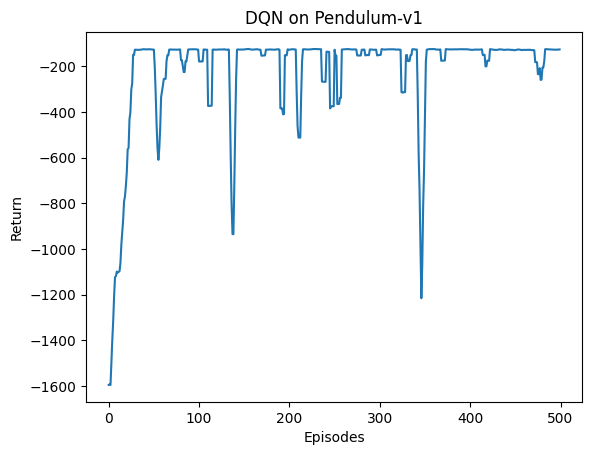

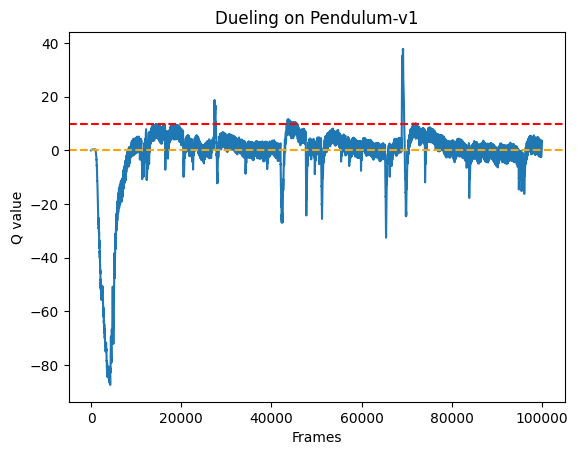

In [38]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, 
            target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling on {}'.format(env_name))
plt.show()

## 8.6. Summary